<a href="https://www.kaggle.com/code/averma111/pytorch-tabular-pss3e17?scriptVersionId=134755617" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
%%capture
!pip install pytorch_tabular[all]

In [26]:
import numpy as np 
import pandas as pd 
import os
import datetime
import seaborn as sns
from tqdm.notebook import tqdm
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score


from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig
from pytorch_tabular.utils import get_balanced_sampler, get_class_weighted_cross_entropy




import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
import itertools

In [20]:
class Utils:
    
    def make_imbalanced_mixed_classification(self,n_samples, n_features, n_categories):
        X,y = make_classification(n_samples=n_samples, n_features=n_features, random_state=42, n_informative=5, weights=[0.7], flip_y=0.3)
        cat_cols = random.choices(list(range(X.shape[-1])),k=n_categories)
        num_cols = [i for i in range(X.shape[-1]) if i not in cat_cols]
        for col in cat_cols:
            X[:,col] = pd.qcut(X[:,col], q=4).codes.astype(int)
        col_names = [] 
        num_col_names=[]
        cat_col_names=[]
        for i in range(X.shape[-1]):
            if i in cat_cols:
                col_names.append(f"cat_col_{i}")
                cat_col_names.append(f"cat_col_{i}")
            if i in num_cols:
                col_names.append(f"num_col_{i}")
                num_col_names.append(f"num_col_{i}")
        X = pd.DataFrame(X, columns=col_names)
        y = pd.Series(y, name="target")
        data = X.join(y)
        return data, cat_col_names, num_col_names

    def print_metrics(self,y_true, y_pred, tag):
        if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
            y_true = y_true.values
        if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
            y_pred = y_pred.values
        if y_true.ndim>1:
            y_true=y_true.ravel()
        if y_pred.ndim>1:
            y_pred=y_pred.ravel()
        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred)
        print(f"{tag} Acc: {val_acc} | {tag} F1: {val_f1}")
        return val_acc, val_fi


In [5]:
class Datapreparation(object):
    
    def __init__(self,root_path):
        self.root_path = root_path
        
    def get_dataframe(self,filename):
        return pd.read_csv(os.path.join(self.root_path,filename))
    
    def summary(self,text, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()
        return summary
    
    def rename_column(self,df):
        updated_df=df.rename(columns=
                             {"Product ID": "Product_ID", 
                              "Air temperature [K]": "Air_temperature",
                             "Process temperature [K]":"Process_temperature",
                             "Rotational speed [rpm]":"Rotational_speed",
                             "Torque [Nm]":"Torque",
                             "Tool wear [min]":"Tool_wear",
                             "Machine failure":"Machine_failure"}
                            )
        return updated_df
    
    def set_label(self,df):
        self.label = 'Machine_failure'
        return df[self.label]
    
    def set_feature(self,df):
        encoder = LabelEncoder()
        df['Type'] = encoder.fit_transform(df['Type'])
        return df
    
    
    def reduce_oversampling(self,X,y):
        smote_nc = SMOTENC(categorical_features=[0, 6, 7, 8, 9, 10], random_state=42)
        return smote_nc.fit_resample(X,y)

    
    
    def random_split_data(self,X,y):
        return train_test_split(X, y,test_size=0.20,random_state=42)

 
    def standardization_data(self,X_data):
        scaler = StandardScaler()
        std_X_data = scaler.fit_transform(X_data)
        return std_X_data
    

    
data = Datapreparation('/kaggle/input/playground-series-s3e17')
train=data.get_dataframe('train.csv')
train = data.rename_column(train)


In [6]:
data.summary('train',train)

,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,136429,0,68214.0,136428,68214.000000,39383.804275,0
Product_ID,object,0,9976,H29424,NaN,M24859,NaN,NaN,0
Type,object,0,3,H,NaN,M,NaN,NaN,0
Air_temperature,float64,0,95,295.3,300.0,304.4,299.862776,1.862247,0
Process_temperature,float64,0,81,305.8,310.0,313.8,309.941070,1.385173,0
Rotational_speed,int64,0,952,1181,1493.0,2886,1520.331110,138.736632,0
Torque,float64,0,611,3.8,40.4,76.6,40.348643,8.502229,0
Tool_wear,int64,0,246,0,106.0,253,104.408901,63.965040,0
Machine_failure,int64,0,2,0,0.0,1,0.015744,0.124486,0
TWF,int64,0,2,0,0.0,1,0.001554,0.039389,0


In [7]:
class EDA:
    
    def plot_numerical_distributions(self,dataframe, columns_to_plot, num_rows, num_cols):
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))
        axes = axes.flatten()
        for i, column in enumerate(columns_to_plot):
            sns.histplot(data=dataframe, x=column, hue='Type', kde=True, multiple='stack', ax=axes[i])
            axes[i].set_title(f"Distribution Plot: {column}")
            axes[i].set_xlabel(column)
            axes[i].legend(title='Type', labels=['L', 'M', 'H'])

        if len(columns_to_plot) < num_rows * num_cols:
            for j in range(len(columns_to_plot), num_rows * num_cols):
                fig.delaxes(axes[j])
        fig.suptitle("Distribution Plots for Numerical Features", fontsize=24, fontweight='bold', y=1.10)
        fig.tight_layout()
        plt.show()
        
        
    def plot_machine_reasons(self,trian):
        reason_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
        failures_data = train[train['Machine_failure'] == 1]
        reason_counts = failures_data[reason_columns].sum()
       # Create a colormap
        cmap = plt.get_cmap('rainbow')
        colors = cmap(np.linspace(0, 1, len(reason_columns)))
       # Plot the reason counts
        plt.figure(figsize=(8, 6))
        bars = plt.bar(reason_columns, reason_counts, color=colors)
       # Add count labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

        plt.xlabel('Reasons for Machine Failures')
        plt.ylabel('Count')
        plt.title('Reasons for Machine Failures (Machine_failure = 1)')
        plt.show()
        
    def plot_outliers(self,train,numerical_columns):
        plt.figure(figsize=(10,6))
        for i, column in enumerate(numerical_columns):
            plt.subplot(2, 3, i+1)
            sns.boxplot(data=train[column])
            plt.title(f'Boxplot: {column}')
            plt.xlabel(column)
        plt.tight_layout()
        plt.show()
        
        
    def plot_roc(self,fpr,tpr):
        plt.rcParams['agg.path.chunksize'] = 100000
        # Plot the ROC curve
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr,marker='.')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

In [8]:
eda = EDA()

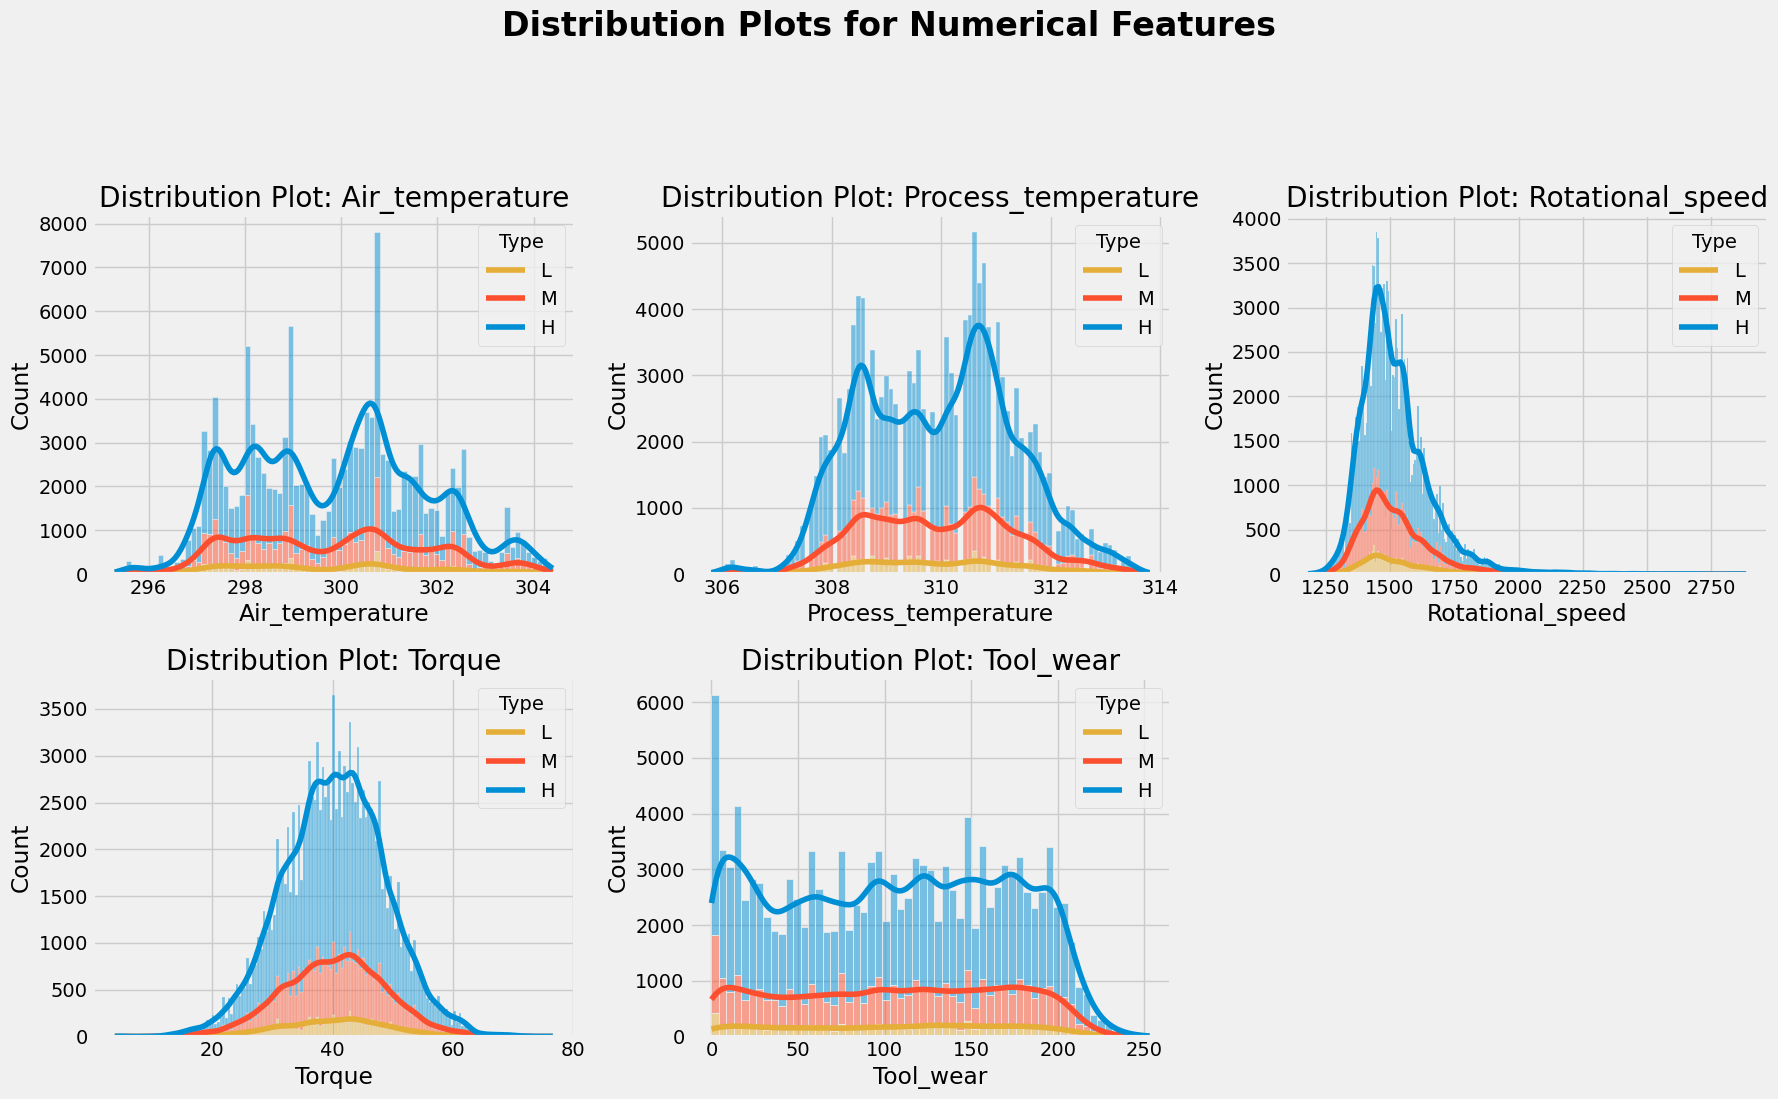

In [9]:
num_rows = 2
num_cols = 3
columns_to_plot = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 
                             'Torque', 'Tool_wear']
eda.plot_numerical_distributions(train, columns_to_plot, num_rows, num_cols)

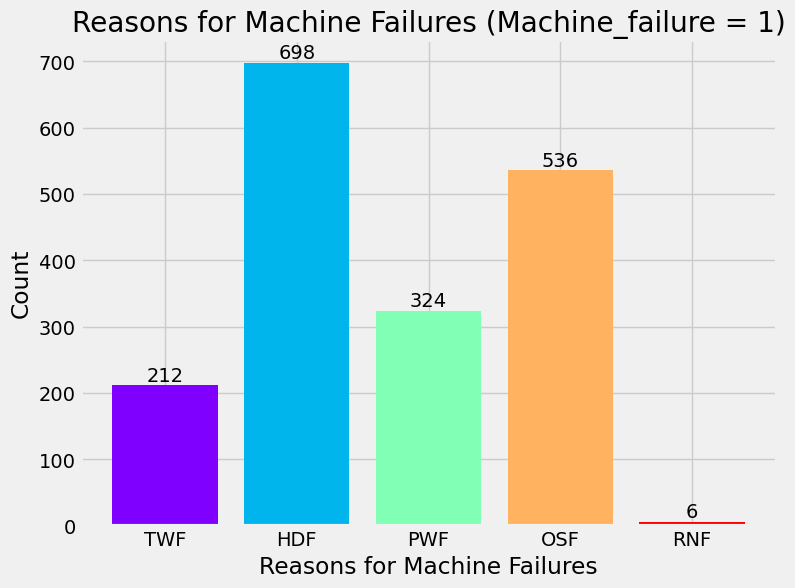

In [10]:
eda.plot_machine_reasons(train)

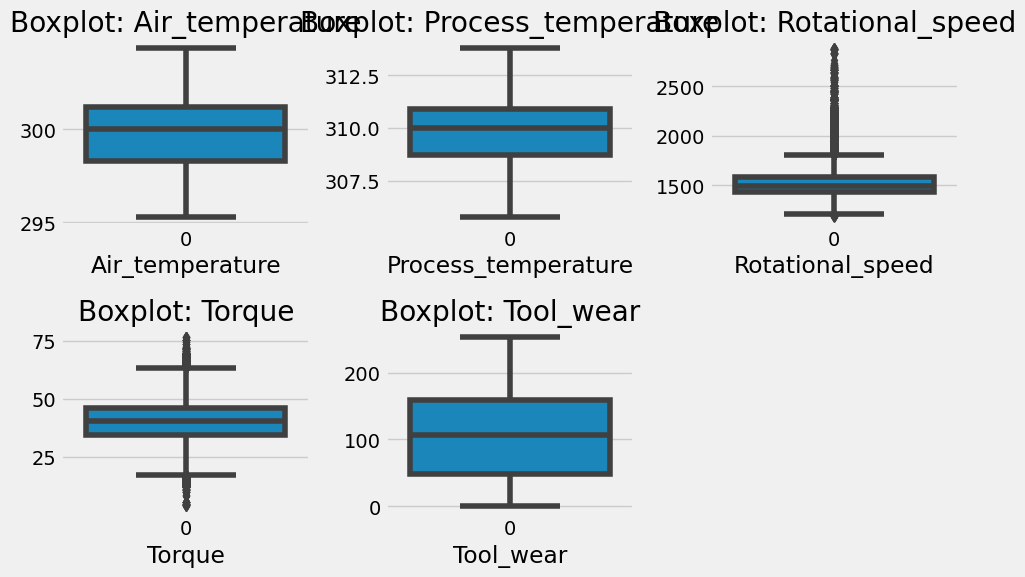

In [11]:
eda.plot_outliers(train,columns_to_plot)

In [12]:
train_updated = data.set_feature(train)
train_updated.drop(columns=['id','Product_ID'],axis=1,inplace=True)
train_updated.head()

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,2,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,1,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,1,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,2,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [13]:
y = data.set_label(train)
X_resampled,y_resampled = data.reduce_oversampling(train_updated,y)
X_train,X_val,y_train,y_val = data.random_split_data(X_resampled,y_resampled)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(214849, 12) (53713, 12) (214849,) (53713,)


In [14]:
std_X_train = data.standardization_data(X_train)
std_X_val = data.standardization_data(X_val)
print(std_X_train[0],std_X_val[0])

[-0.27822181 -1.72018222 -1.32389097 -0.96206009  0.92759186  1.13736702
  0.99979057 -0.17967389 -0.45829591 -0.21741065  2.99836435 -0.03358039] [-0.27148309  0.01838727 -0.65203409  0.17594555  0.52073436 -1.61905775
 -0.99916256 -0.17846828 -0.45322008 -0.21394658 -0.33487232 -0.03507513]


In [21]:
utils = Utils()

data, cat_col_names, num_col_names = utils.make_imbalanced_mixed_classification(n_samples=10000, n_features=20, n_categories=4)

NameError: name 'make_classification' is not defined

In [24]:
class Configs:
    
    """Data Configuration"""
    data_config = DataConfig(
    target=['Machine_Failure'], 
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
    )
    
    """Trainer Configuration"""
    trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=256,
    max_epochs=100,
    early_stopping="valid_loss", # Monitor valid_loss for early stopping
    early_stopping_mode = "min", # Set the mode as min because for val_loss, lower is better
    early_stopping_patience=5, # No. of epochs of degradation training will wait before terminating
    checkpoints="valid_loss", # Save best checkpoint monitoring val_loss
    load_best=True, # After training, load the best checkpoint
#     accelerator="cpu"
    )
    
    """Optimizer Configuration"""
    optimizer_config = OptimizerConfig()
    
    head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
    ).__dict__ 
    
    """Model Configuration"""
    model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="8-4-4",  # Number of nodes in each layer
    activation="LeakyReLU", # Activation between each layers
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
    learning_rate = 1e-3,
    metrics=["f1_score","accuracy"], 
    metrics_params=[{"num_classes":2},{}],
    metrics_prob_input=[True, False]
)
    
config = Config()

NameError: name 'num_col_names' is not defined

In [25]:
class Trainer:
    
    """Training Configuration"""
    tabular_model = TabularModel(
    data_config=config.data_config,
    model_config=config.model_config,
    optimizer_config=config.optimizer_config,
    trainer_config=config.trainer_config,
)

NameError: name 'config' is not defined

In [ ]:
trainer = Trainer()
trainer.tabular_model.fit(train=train, validation=val)


In [ ]:
result = tabular_model.evaluate(test)


In [ ]:
result = {k: float(v) for k,v in result[0].items()}
result["mode"] = "Normal"

results.append(result)


In [ ]:
class Balancedsampler:
    
tabular_model = TabularModel(
    data_config=config.data_config,
    model_config=config.model_config,
    optimizer_config=config.optimizer_config,
    trainer_config=config.trainer_config,
)
sampler = get_balanced_sampler(train['target'].values.ravel())


bal = Balancedsampler()

In [ ]:
bal.tabular_model.fit(train=train, validation=val, train_sampler=sampler)

In [ ]:
result = tabular_model.evaluate(test)


In [ ]:
result = {k: float(v) for k,v in result[0].items()}
result["mode"] = "Balanced Sampler"

results.append(result)


In [ ]:
class Weightedsampler:
    
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
weighted_loss = get_class_weighted_cross_entropy(train["target"].values.ravel(), mu=0.1)


ws = Weightedsampler()

In [ ]:
ws.tabular_model.fit(train=train, validation=val, loss=weighted_loss)

In [ ]:
result = tabular_model.evaluate(test)


In [ ]:
result = {k: float(v) for k,v in result[0].items()}
result["mode"] = "Class Weights"

results.append(result)


In [ ]:
res_df = pd.DataFrame(results).T
res_df.columns = res_df.iloc[-1]
res_df = res_df.iloc[:-1].astype(float)
res_df.style.highlight_min(color="lightgreen",axis=1)
